In [33]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import corner
import time
from chainconsumer import ChainConsumer
from chainconsumer import analysis
import MCMC_PAD_functions as pad

## *What is the problem?*
### Evaluating a function $P(\theta | \rm{other\ stuff})$ as a function of $\theta$ (e.g. posterior probability of parameters)

In [3]:
# priors for all parameters
prior_min, prior_max = 0.0, 19.0

# number of grid points per dimension
n_grid = 20

## One dimension

In [36]:
theta_0_1d = np.linspace(prior_min,prior_max,n_grid)

log_posterior_1d = np.zeros(theta_0_1d.shape)

for i in range(n_grid):
    log_posterior_1d[i] = pad.log_function_nd([theta_0_1d[i]])


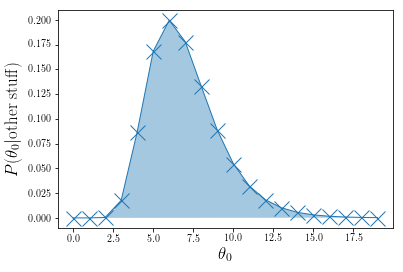

In [37]:
pad.plot_normalised_1d(theta_0_1d, log_posterior_1d)

## 2D grid (15 x 15 = 225 evaluations of the posterior)

In [38]:
theta_0, theta_1 = np.mgrid[prior_min:prior_max:n_grid*1j,prior_min:prior_max:n_grid*1j]
theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()

In [39]:
log_posterior = np.zeros(theta_0.shape)

for i in range(len(log_posterior)):
    log_posterior[i] = log_function_nd([theta_0[i], theta_1[i]])

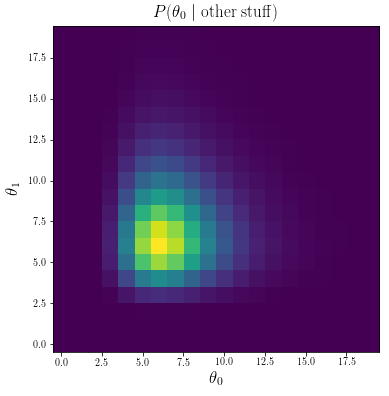

In [40]:
pad.plot_normalised_2d(theta_0, theta_1, log_posterior, n_grid)

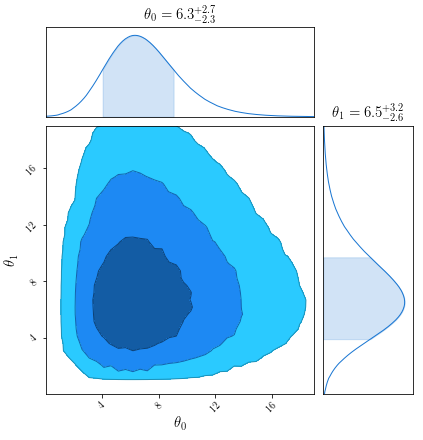

In [41]:
c = ChainConsumer()

weights_array1 = np.reshape(np.exp(log_posterior),-1)
weights_array1 += np.min(weights_array1[np.where(weights_array1>0)])

c.add_chain([theta_0, theta_1],
            parameters=[r'$\theta_0$', r'$\theta_1$'],
            weights=weights_array1, grid=True)


c.configure(kde= [1.], sigmas = [1,2, 3],
            contour_label_font_size = 19,
            label_font_size = 15, shade = True)

fig = c.plotter.plot(figsize = (6,6))

## 6 dimensions (e.g. 15^6 ~ 11 million evaluations of the posterior)

In [12]:
theta_0, theta_1, theta_2, theta_3,\
theta_4, theta_5 = np.mgrid[prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j]

theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()
theta_2 = theta_2.flatten()
theta_3 = theta_3.flatten()
theta_4 = theta_4.flatten()
theta_5 = theta_5.flatten()

In [ ]:
# This will take forever

log_posterior_6d = np.zeros(theta_0.shape)

for i in range(len(log_posterior_6d)):
    log_posterior_6d[i] = log_function_nd([theta_0[i],
                                           theta_1[i],
                                           theta_2[i],
                                           theta_3[i],
                                           theta_4[i],
                                           theta_5[i]])

In [13]:
print(i)

399


# MCMC to the rescue!

In [14]:
def initial_parameters(theta, relative_sigma):
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [15]:
n_dim6d=6
n_burn6d=100
n_steps6d = 4000
n_walkers6d = 2 * n_dim6d

In [16]:
theta6d_expected_mean = [10]*n_dim6d

theta_init_6d = [list(initial_parameters(theta6d_expected_mean, 0.1)) for i in range(n_walkers6d)]

In [17]:
def posterior6d_hard_prior(theta, prior_min, prior_max):
#     print(theta)
    if any(val > prior_max for val in theta):
#         print(theta)
        return 1e18*(log_function_nd(theta))
    elif any(val < prior_min for val in theta):
#         print(theta)
        return 1e18*(log_function_nd(theta))
    else:
        return (log_function_nd(theta))
    

sampler6d = mc.EnsembleSampler(n_walkers6d, n_dim6d, posterior6d_hard_prior,
                             args=(prior_min, prior_max))

In [18]:
print('burning')
startTime=time.time()
pos, prob, state =  sampler6d.run_mcmc(theta_init_6d, n_burn6d)
read_chain=np.array(sampler6d.chain[:,:,:])
endTime=time.time()
totalTime=endTime-startTime
print(totalTime)

burning
0.711129903793335


In [19]:
# sampler.reset() #lose the written chain
t = time.time()
pos,prob,state=sampler6d.run_mcmc(pos, n_steps6d) #start from where we left off previously 

print(time.time() - t)
read_chain=np.array(sampler6d.chain[:,n_burn6d:,:]) #get chain for writing
read_chain=read_chain.astype(float)


9.234105825424194


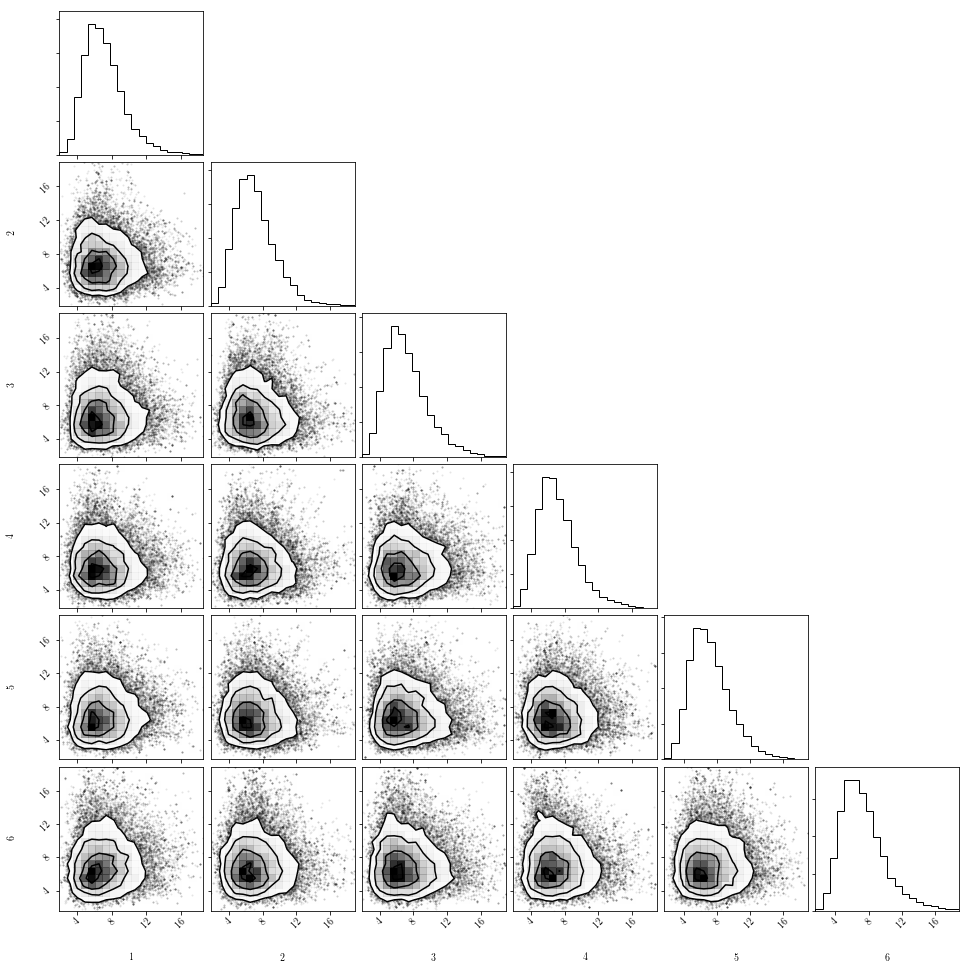

In [20]:
samples6d = read_chain.reshape((-1, n_dim6d))
fig = corner.corner(samples6d, labels=['1', '2', '3', '4', '5', '6'])

## Use it for the low dimensional stuff?

In [21]:
n_burn1d=1000
n_steps1d = 1200
n_samples1d = 2 * (n_steps1d - n_burn1d)

print('Number of samples = ' + str(n_samples1d))

theta_init_1d = [list(initial_parameters([10], 0.1)) for i in range(2)]

Number of samples = 400


In [22]:
sampler1d = mc.EnsembleSampler(n_walkers1d, 1, posterior6d_hard_prior,
                             args=(prior_min, prior_max))


NameError: name 'n_walkers1d' is not defined

In [ ]:
pos, prob, state =  sampler1d.run_mcmc(theta_init_1d, n_steps1d)
samples1d=np.array(sampler1d.chain[:,n_burn1d:,:]).flatten()

In [ ]:
theta_0_1d_fine = np.linspace(prior_min,prior_max,n_grid*10-9)

log_posterior_1d_fine = np.zeros(theta_0_1d_fine.shape)

for i in range(len(log_posterior_1d_fine)):
    log_posterior_1d_fine[i] = log_function_nd([theta_0_1d_fine[i]]) 


In [ ]:
_ = plt.plot(theta_0_1d, np.exp(log_posterior_1d)/np.sum(np.exp(log_posterior_1d)), marker = 'x', ms = 15,  lw=0, label = '20 grid points')
_ = plt.hist(samples1d, normed = True, histtype ='step', bins = np.linspace(0,19,20), label = str(n_samples1d) + ' samples')
_ = plt.plot(theta_0_1d_fine, 10.0*np.exp(log_posterior_1d_fine)/np.sum(np.exp(log_posterior_1d_fine)),  label = 'True function')
_ = plt.ylabel(r'$P(\theta_0| \rm{other\ stuff})$', fontsize = 17), plt.xlabel(r'$\theta_0$', fontsize = 17)
_ = plt.legend(fontsize = 17)

# If the samples match the underlying distribution, the MCMC has "converged"